In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyreadstat
import re
import string
from sklearn_pandas import DataFrameMapper
import networkx as nx
import reed
from clean import *


pd.options.display.max_columns=100
pd.options.display.max_colwidth=200
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [ ]:
#TODO merge treatment and outcomes into the datasets created and update the load data functions correspondingly

# Parameters

In [ ]:
# list(zip(range(2001,2020),string.ascii_lowercase)) # list the letter code for each year

s,m,e = 'a','q','s' # select which waves to base analysis on
min_start_age = 25 # the minimum age people must as of the starting wave
missing_threshold = 0.95

# Data Structure

- part1 contains the combined data from all questionairs asked in a given wave. Each wave is a separate file (eg a s wave 1, be is wave 2, etc. 
- TODO understand the note in HILDA manual that concepts that contained both positive and negative values were split across multiple columns. 

#### Outcomes measures
   - **hours worked** Largly missing. The following variables are perfectly correlated
      - `ajbhru` 57% missing, *E1b Hours per week usually worked in all your jobs*
      - `ajbhruc`,57% missing *DV: Hours per week usually worked in all jobs*
   - **wages (not normalised by hours worked)**
      - `awsfe` wages from all jobs last financial year with imputation from net
      - `awsce` current weekly wages from all jobs with imputation from net
      - Non-imputed versions of both of these exist (replace the final `e` with `g`) but have slightly more missing values
      - `awsfhave` records if people have received income from salary/wages last financial year. We could also use `_esbrd` to tell if people should have a non-zero wage.
      - wage variables have quite a lot of missing data (~33% missing `awsfe` and 30% missing both `awsfe` and `awsfhave`)
      - There are versions of wage variables with imputation of missing data from based on responses from the participant in other waves and responses from similar participants. These are indicated by the suffix `i` (eg `awsfei`, `awscei`). These variables contain no missing data.
   - **employment status (categorical outcome)**
   - **mental health**
   
#### Treatment measures
   - Treatment is based on a change in education qualification between 2001 and 2017
   - There are a number of study related variables that are only recorded on a subset of the waves. 
   - _edq{XXX} variables are recorded every year and count the number of qualifications a person holds in each of a number of categories


In [ ]:
# read the combined file for the starting wave
df1, meta1 = pyreadstat.read_sav(f'../part1/Combined {s}190c.sav') 
n0 = len(df1)
print(f"Number of people in initial wave {n0}")

### Compute treatment & outcomes

In [ ]:
from treatment_outcomes import compute_treatment_vars, compute_outcomes
treatments = compute_treatment_vars(df1, s, m)
outcomes = compute_outcomes(e)

In [ ]:
treatment_outcomes = pd.merge(treatments,outcomes,on='xwaveid',how='inner')
treatment_outcomes['xwaveid'] = treatment_outcomes['xwaveid'].astype(int)
treatment_outcomes.shape

In [ ]:
from reed import compute_confusion
# It's a bit surprising that that there are so many for whome the highest qualification, but the counts has not. 
compute_confusion(treatments['redudl'],treatments['reduhl'],'dl','dh')

## Extract basic variables
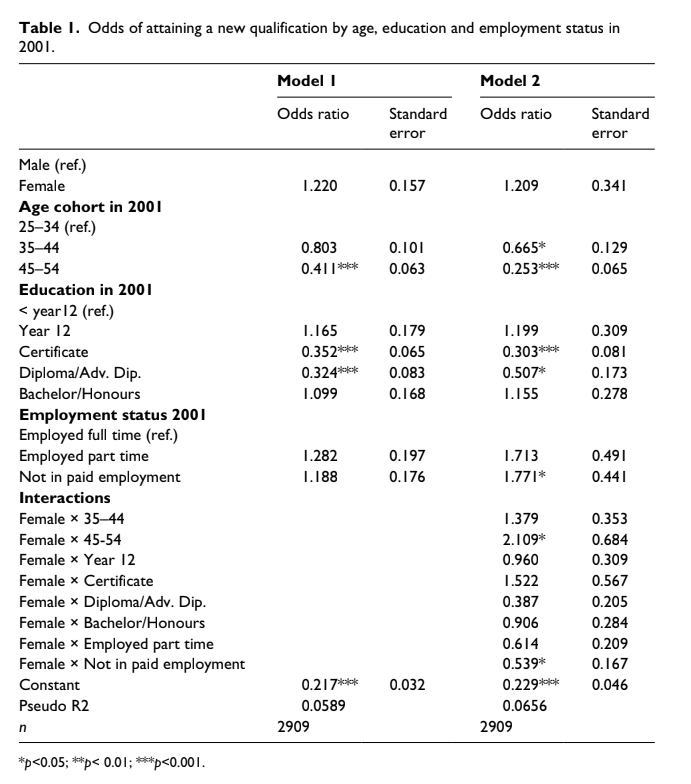

In [ ]:
from treatment_outcomes import simplify_employment
from reed import regex_select

def extract_basic_variables(df):
    # age, sex, education in 2001, employment status in 2001
    basic = df1[['xwaveid','ahgage','ahgsex','aedhigh1','aesdtl']].copy() 

    def simplify_education(v):
        """Simplify down to match categories in paper."""
        if v < 0 or v==10:
            return np.nan # missing
        if v < 3: #(above bachelors)
            return 2
        return v # < year 12:(9), year 12:(8), cert:(5), diploma/adv diploma:(4), bachelors/honours:(3)

    # remove under 25s
    basic = basic[basic['ahgage']>25].copy()
    
    # simplify education & employment in line with baseline paper
    basic['aesdtl']=basic['aesdtl'].apply(simplify_employment)
    basic['aedhigh1'] = basic['aedhigh1'].apply(simplify_education)
    
    # bin age
    basic['ahgage'] = pd.cut(basic['ahgage'],bins=[24,34,44,54,120])
    
    # dummy encode
    basic = pd.get_dummies(basic,columns=['ahgage','ahgsex','aedhigh1','aesdtl'],drop_first=True)
    
    # add interactions between gender and other variables
    age_edu_emp = regex_select(basic.columns,['^ahgage_','^aedhigh1_','^aesdtl_'])
    basic = create_interaction_columns(basic,['ahgsex_2.0'],age_edu_emp)
    basic['xwaveid'] = basic['xwaveid'].astype(int)
    return basic

basic = extract_basic_variables(df1)
l0 = len(basic)
basic = pd.merge(basic,treatment_outcomes,on='xwaveid',how='inner')
l1 = len(basic)
print(f"Dropped {l0-l1} individuals who are not present in waves {m} and {e} ({100*(l0-l1)/l0:.0f}%)")
basic.to_csv("basic_variables.csv",index=False)

## Extract Full variable set

### Filter out rows containing people who were already studying at wave 1

In [ ]:
def filter_participants(df1,min_start_age):
    """
    Remove those already studying or below the minimum age in the initial wave.
    """
    n0 = len(df1)
    df = df1.loc[df1[f'{s}hgage'] >= min_start_age].copy()
    print(f"Dropping {n0-len(df)} participants below age {min_start_age}")

    # filter out those already studying

    # If any of the following are > 0, then the respondant was already studying at the beginning of the period
    already_studying_cols = [s+col for col in ['caeft','caept','nlreast','bncsty','bnfsty']]

    already_studying = df[already_studying_cols].sum(axis=1)

    n0 = len(df)
    df = df[already_studying < 1].copy()
    print(f"Dropping {n0-len(df)} participants already studying at period start")
    print(f"Remaining participants:{len(df)}")
    return df

### Filter out columns based on annotated spreadsheet

In [ ]:
def read_type_information():
    headers = ['variable','vartype','format','label','long_label','varcat','relevance',"0"]
    type_df = pd.read_csv("HILDAw1vardic.csv",skiprows=4,index_col=None, names=headers)
    type_df['relevance'] = type_df['relevance'].fillna(1).astype(int)
    type_df.loc[type_df['label']=='ACAEPT','relevance'] = -1
    return type_df

def drop_irrelevant_columns_inplace(df, type_df):
    irrelevant = list(type_df.loc[type_df['relevance']<1,'variable'])
    irrelevant.remove('xwaveid')
    df.drop(columns=irrelevant,inplace=True)
    print(f"Dropped {len(irrelevant)} irrelevant columns.")
    return irrelevant
    

### Fix types

In [ ]:
def fix_types_inplace(df1):
    # Reformat some of the columns
    dates = ["ahhhqivw","ahhcompi","ahhcompf","ahhcomps","ahhidate"]
    string = ['ahhtitle']
    categorical = [
     'acca1',
     'acca2',
     'ahhmgfxd',
     'ahhmgmxd',
     'ahhp1',
     'ahhp2',
     'ahhp3',
     'ahhpgfxd',
     'ahhpgmxd',
     'ahhpno',
     'xwaveid'
    ]

    for c in categorical:
        if c in df1.columns:
            df1[c] = pd.to_numeric(df1[c])

    # turn into days past epoch
    basedate = pd.to_datetime('01/01/1900',format='%d/%m/%Y')    
    for c in dates:
        if c in df1.columns:
            df1[c] = (pd.to_datetime(df1[c],format='%d/%m/%Y',errors='coerce')-basedate).dt.days 

    for c in string:
        df1[c] = df1[c].astype('category').cat.codes
        


### Automatic (very basic) column filtering

In [ ]:
def filter_raw_data(min_age=25, threshold=0.99):
    df1, meta1 = pyreadstat.read_sav(f'../part1/Combined {s}190c.sav') 
    print("Read in data, with shape:",df1.shape)
    df1 = filter_participants(df1,min_age)
    
    columns_dropped = {} # keep track of why each column was dropped
    
    type_df = read_type_information()
    irrelevant = drop_irrelevant_columns_inplace(df1,type_df)
    add_list_to_dict(irrelevant,columns_dropped,'invalid/irrelevant')

    fix_types_inplace(df1)
    
    constant = drop_constant_columns(df1)
    add_list_to_dict(constant,columns_dropped,'constant')

    mostly_missing = drop_mostly_missing_columns(df1, threshold = threshold)
    drop_strongly_correlated_columns(df1,columns_dropped,threshold=threshold,inplace=True,fillna=True)
    
    print("Processed data, with shape:",df1.shape)
    return df1, columns_dropped

def drop_strongly_correlated_columns(df, columns_dropped,threshold=0.99, inplace=True, fillna=True):
    """
    Drop columns that are highly correlated with another column.
    
    In each strongly connected component, the variable with the least missing data will be the 
    representative variable kept.
    """
    d = df.fillna(-1)
    c = compute_correlations(d)
    del d
    strong = c[c['correlation'].abs() > threshold]
    print(f"number of strong correlations stronger than {threshold:.2f} is: {len(strong)}")
    g = nx.Graph()
    g.add_edges_from(list((strong[['c1','c2']]).itertuples(index=False,name=None)))
    components = list(nx.connected_components(g))
    print("Number of connected components in strong correlation graph:",len(components))
    
    drop = set({})
    for component in components:
        least_missing = df[list(component)].isnull().sum(axis=0).idxmin()
        component.remove(least_missing)
        drop = drop.union(component)
        add_list_to_dict(component,columns_dropped,f"merged into {least_missing}")
    print("Columns dropped due to almost perfect correlation:",len(drop))
    if inplace:
        df.drop(columns=drop,inplace=True)
    return drop, columns_dropped

In [ ]:
df, columns_dropped = filter_raw_data(threshold=missing_threshold)
l0 = len(df)
df = pd.merge(df,treatment_outcomes,on='xwaveid',how='inner')
l1 = len(df)
print(f"Dropped {l0-l1} individuals who are not present in waves {m} and {e} ({100*(l0-l1)/l0:.0f}%)")
df.to_csv(f"all_vars_{int(round(missing_threshold*1000))}.csv",index=False)